<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data-Augmentation/Analysis" data-toc-modified-id="Data-Augmentation/Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Augmentation/Analysis</a></span></li><li><span><a href="#Dataloader-creation-and-test" data-toc-modified-id="Dataloader-creation-and-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataloader creation and test</a></span></li><li><span><a href="#Model-creation" data-toc-modified-id="Model-creation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model creation</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Model-Testing" data-toc-modified-id="Model-Testing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Testing</a></span></li></ul></li></ul></div>

**GET DATA**

Summary of this notebook: ...

Definition of Done: ...

# Imports


In [1]:
# Imports from Colab 2
import math
import numpy as np
import pickle
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import model architecture
# from tensorflow.keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# Imports for Colab 6
import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2 # Read raw image
import glob
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
# from scipy import ndimage # For rotation task or
# import imutils
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator


# Imports for Colorizer
from os import path
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from skimage.color import rgb2lab, lab2rgb, rgb2gray
# from skimage.io import imsave
import random
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import RMSprop
import time

import tensorflow.keras.backend as K

In [3]:
# Check to see if GPU is being used
tensorflow.test.gpu_device_name()


'/device:GPU:0'

# Dataloader creation and test

In [4]:
dims=(448,448,2)

train_name='../ssd/proxy_data/merced_xtrain_448.npy'
test_name='../ssd/proxy_data/merced_xtest_448.npy'

if path.exists(train_name):
  print("Train exists")
  X_train_reshaped=np.load(train_name)
else:
  X_train=np.empty((0,*dims))

if path.exists(test_name):
  print("Test exists")
  X_test_reshaped=np.load(test_name)
else:
  X_test=np.empty((0,*dims))

Train exists
Test exists


In [5]:
batch_size = 16

AUTOTUNE=tensorflow.data.experimental.AUTOTUNE

def convert(image):
    image=tensorflow.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
    current_min=tf.math.reduce_min(image)
    current_max=tf.math.reduce_max(image)
#     print(current_min,current_max)
    image_normed=(image-current_min)/(current_max - current_min)
    
    # GB->R
    feat_1=tf.gather(image_normed,indices=[1,2], axis=-1)
    label_1=image_normed[:,:,0]
    
    # RB->G
    feat_2=tf.gather(image_normed,indices=[0,2], axis=-1)
    label_2=image_normed[:,:,1]
    
    # RG->B
    feat_3=tf.gather(image_normed,indices=[0,1], axis=-1)
    label_3=image_normed[:,:,2]
    return feat_1,label_1,feat_2,label_2,feat_3,label_3



train_dataset = tf.data.Dataset.from_tensor_slices((X_train_reshaped))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_reshaped))

train_dataset = train_dataset.map(convert, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(buffer_size=12*batch_size)
train_dataset = train_dataset.batch(batch_size)
# train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.map(convert, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.cache()
test_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Model creation

In [6]:
def encoder(input_shape):

    model = Sequential(name="encoder")
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(64, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(128, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(256, (3, 3), padding="same", strides=2))
    model.add(PReLU())
    model.add(Conv2D(15, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(5, (3, 3), padding="same"))
    model.add(PReLU())
    return model

def decoder(input_shape):
    model = Sequential(name="decoder")
    model.add(Input(shape=input_shape))
    model.add(Conv2DTranspose(128, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(64, (3, 3),padding="same"))
    model.add(PReLU())
    model.add(Conv2DTranspose(64, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(32, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(Conv2D(3, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(3, (3, 3), padding="same"))
    model.add(PReLU())
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(1, (3, 3), activation="tanh", padding="same"))
    return model

In [7]:
encoder_model=encoder(dims)
encoding_depth=20
decoder_model=decoder(encoder_model.output_shape[1:])

model_1=Sequential()
model_1.add(encoder_model)
model_1.add(decoder_model)
# GB->R
model_1.build(input_shape=(None,*dims))
# RB->G
model_2=tf.keras.models.clone_model(model_1)
 # RG->B
model_3=tf.keras.models.clone_model(model_1)


# model.compile(optimizer='rmsprop', loss=custom_loss)
# model.summary()
opt=RMSprop(learning_rate=1e-3)

In [8]:
def custom_loss(y_true,y_pred): # Issue-> Non differentiable function
    # y_true,y_pred of the shape (bs,h,w,n_c)
    loss=tf.Variable(0.,tf.float32)
    for i in range(3):
        y_true_ch=tf.reshape(y_true[:,:,:,i],[-1])
        y_pred_ch=tf.reshape(y_pred[:,:,:,i],[-1])
        y_true_hist=tf.histogram_fixed_width(y_true_ch, value_range=(0., 1.), nbins=10) 
        y_pred_hist=tf.histogram_fixed_width(y_pred_ch, value_range=(0., 1.), nbins=10) 
        y_true_hist=tf.cast(y_true_hist,dtype=tf.dtypes.float32)
        y_pred_hist=tf.cast(y_pred_hist,dtype=tf.dtypes.float32)
        ch_loss=K.mean(K.square(y_true_hist-y_pred_hist))
        loss=tf.math.add(loss,ch_loss)
    return loss


def bce_loss(y_true,y_pred):
    loss=tf.Variable(0.,tf.float32)
    for i in range(3):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.25)
        y_true_ch=tf.reshape(y_true[:,:,:,i],[-1])
        y_pred_ch=tf.reshape(y_pred[:,:,:,i],[-1])
        loss_ch=bce(y_true_ch,y_pred_ch)
        loss=tf.math.add(loss,loss_ch)
    return loss
    
def concatenated_loss_mse(y_true1,y_pred1,y_true2,y_pred2,y_true3,y_pred3):
    loss=tf.Variable(0.,tf.float32)
    mse=tf.keras.losses.MeanSquaredError()
    loss_1=mse(y_true1,y_pred1)
    loss_2=mse(y_true2,y_pred2)
    loss_3=mse(y_true3,y_pred3)
#     loss=tf.math.scalar_mul(loss_1,(1/3))+tf.math.scalar_mul(loss_2,(1/3))+tf.math.scalar_mul(loss_3,(1/3))
    loss=loss_1*(1/3)+loss_2*(1/3)+loss_3*(1/3)
    
    return loss

def concatenated_loss_bce(y_true1,y_pred1,y_true2,y_pred2,y_true3,y_pred3):
    y_true1=tf.reshape(y_true1,[-1])
    y_pred1=tf.reshape(y_pred1,[-1])
    
    y_true2=tf.reshape(y_true2,[-1])
    y_pred2=tf.reshape(y_pred2,[-1])
    
    y_true3=tf.reshape(y_true3,[-1])
    y_pred3=tf.reshape(y_pred3,[-1])
    
    loss=tf.Variable(0.,tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.25)
    loss_1=bce(y_true1,y_pred1)
    loss_2=bce(y_true2,y_pred2)
    loss_3=bce(y_true3,y_pred3)
#     loss=tf.math.scalar_mul(loss_1,(1/3))+tf.math.scalar_mul(loss_2,(1/3))+tf.math.scalar_mul(loss_3,(1/3))
    loss=loss_1*(1/3)+loss_2*(1/3)+loss_3*(1/3)
    
    return loss

        
# @tf.function
def step(model1,model2,model3,X1,Y1,X2,Y2,X3,Y3):
    with tf.GradientTape(watch_accessed_variables=True) as tape:
        pred1=model1(X1,training=True)
        pred2=model2(X2,training=True)
        pred3=model3(X3,training=True)
        loss=concatenated_loss_bce(Y1,pred1,Y2,pred2,Y3,pred3)
    grads=tape.gradient(loss,sources=model1.trainable_variables+model2.trainable_variables+model3.trainable_variables)         
    return loss,grads

# @tf.function
def validate(model1,model2,model3,x_v1,y_v1,x_v2,y_v2,x_v3,y_v3):
    pred1=model1(x_v1,training=False)
    pred2=model2(x_v2,training=False)
    pred3=model3(x_v3,training=False)
    valid_loss=concatenated_loss_bce(y_v1,pred1,y_v2,pred2,y_v3,pred3)
    return valid_loss

In [9]:
train_loss=[]
val_loss=[]
for epoch in range(100):
    t_start=time.time()
    train_epoch_loss=tensorflow.keras.metrics.Mean()
    val_epoch_loss=tensorflow.keras.metrics.Mean()
    
    for batch_idx,(x_1,y_1,x_2,y_2,x_3,y_3) in enumerate(train_dataset):
        loss,grad=step(model_1,model_2,model_3,x_1,y_1,x_2,y_2,x_3,y_3)
        opt.apply_gradients(zip(grad,model_1.trainable_variables+model_2.trainable_variables+model_3.trainable_variables))
  
        train_epoch_loss.update_state(loss)
        if batch_idx%20==0:
            print("Train Batch Loss at Epoch %d step %d: %.4f"
                % (epoch,batch_idx, float(loss)))
    train_loss.append(train_epoch_loss.result())
                  
    for x_v1,y_v1,x_v2,y_v2,x_v3,y_v3 in test_dataset:
        v_loss=validate(model_1,model_2,model_3,x_v1,y_v1,x_v2,y_v2,x_v3,y_v3)
        val_epoch_loss.update_state(v_loss)
    print("Train loss at Epoch %d: %.4f Time taken %.3f "%(epoch,train_epoch_loss.result(),time.time()-t_start))
    print("\t Val loss at Epoch %d: %.4f "%(epoch,val_epoch_loss.result()))
    val_loss.append(val_epoch_loss.result())
      


Train Batch Loss at Epoch 0 step 0: 6.2966
Train Batch Loss at Epoch 0 step 20: 0.7693
Train Batch Loss at Epoch 0 step 40: 0.7618
Train Batch Loss at Epoch 0 step 60: 0.7652
Train Batch Loss at Epoch 0 step 80: 0.7932
Train Batch Loss at Epoch 0 step 100: 0.7332
Train loss at Epoch 0: 0.9872 Time taken 147.272 
	 Val loss at Epoch 0: 0.7954 
Train Batch Loss at Epoch 1 step 0: 0.8285
Train Batch Loss at Epoch 1 step 20: 0.7237
Train Batch Loss at Epoch 1 step 40: 0.7197
Train Batch Loss at Epoch 1 step 60: 0.7115
Train Batch Loss at Epoch 1 step 80: 0.7125
Train Batch Loss at Epoch 1 step 100: 0.7135
Train loss at Epoch 1: 0.7412 Time taken 140.238 
	 Val loss at Epoch 1: 0.7064 
Train Batch Loss at Epoch 2 step 0: 0.7267
Train Batch Loss at Epoch 2 step 20: 0.7141
Train Batch Loss at Epoch 2 step 40: 0.6976
Train Batch Loss at Epoch 2 step 60: 0.6907
Train Batch Loss at Epoch 2 step 80: 0.7165
Train Batch Loss at Epoch 2 step 100: 0.6648
Train loss at Epoch 2: 0.7054 Time taken 140.2

Train Batch Loss at Epoch 23 step 80: 0.6272
Train Batch Loss at Epoch 23 step 100: 0.6251
Train loss at Epoch 23: 0.6483 Time taken 139.994 
	 Val loss at Epoch 23: 0.6477 
Train Batch Loss at Epoch 24 step 0: 0.6663
Train Batch Loss at Epoch 24 step 20: 0.6691
Train Batch Loss at Epoch 24 step 40: 0.6504
Train Batch Loss at Epoch 24 step 60: 0.6465
Train Batch Loss at Epoch 24 step 80: 0.6470
Train Batch Loss at Epoch 24 step 100: 0.6286
Train loss at Epoch 24: 0.6481 Time taken 139.946 
	 Val loss at Epoch 24: 0.6501 
Train Batch Loss at Epoch 25 step 0: 0.6719
Train Batch Loss at Epoch 25 step 20: 0.6613
Train Batch Loss at Epoch 25 step 40: 0.6633
Train Batch Loss at Epoch 25 step 60: 0.6430
Train Batch Loss at Epoch 25 step 80: 0.6444
Train Batch Loss at Epoch 25 step 100: 0.6269
Train loss at Epoch 25: 0.6480 Time taken 140.174 
	 Val loss at Epoch 25: 0.6488 
Train Batch Loss at Epoch 26 step 0: 0.6670
Train Batch Loss at Epoch 26 step 20: 0.6577
Train Batch Loss at Epoch 26 st

Train loss at Epoch 46: 0.6446 Time taken 139.879 
	 Val loss at Epoch 46: 0.6462 
Train Batch Loss at Epoch 47 step 0: 0.6632
Train Batch Loss at Epoch 47 step 20: 0.6582
Train Batch Loss at Epoch 47 step 40: 0.6532
Train Batch Loss at Epoch 47 step 60: 0.6478
Train Batch Loss at Epoch 47 step 80: 0.6358
Train Batch Loss at Epoch 47 step 100: 0.6341
Train loss at Epoch 47: 0.6445 Time taken 139.952 
	 Val loss at Epoch 47: 0.6434 
Train Batch Loss at Epoch 48 step 0: 0.6636
Train Batch Loss at Epoch 48 step 20: 0.6584
Train Batch Loss at Epoch 48 step 40: 0.6456
Train Batch Loss at Epoch 48 step 60: 0.6505
Train Batch Loss at Epoch 48 step 80: 0.6396
Train Batch Loss at Epoch 48 step 100: 0.6271
Train loss at Epoch 48: 0.6443 Time taken 140.061 
	 Val loss at Epoch 48: 0.6442 
Train Batch Loss at Epoch 49 step 0: 0.6549
Train Batch Loss at Epoch 49 step 20: 0.6509
Train Batch Loss at Epoch 49 step 40: 0.6548
Train Batch Loss at Epoch 49 step 60: 0.6416
Train Batch Loss at Epoch 49 ste

Train Batch Loss at Epoch 70 step 0: 0.6592
Train Batch Loss at Epoch 70 step 20: 0.6557
Train Batch Loss at Epoch 70 step 40: 0.6484
Train Batch Loss at Epoch 70 step 60: 0.6448
Train Batch Loss at Epoch 70 step 80: 0.6378
Train Batch Loss at Epoch 70 step 100: 0.6285
Train loss at Epoch 70: 0.6424 Time taken 139.843 
	 Val loss at Epoch 70: 0.6415 
Train Batch Loss at Epoch 71 step 0: 0.6584
Train Batch Loss at Epoch 71 step 20: 0.6531
Train Batch Loss at Epoch 71 step 40: 0.6484
Train Batch Loss at Epoch 71 step 60: 0.6469
Train Batch Loss at Epoch 71 step 80: 0.6276
Train Batch Loss at Epoch 71 step 100: 0.6199
Train loss at Epoch 71: 0.6423 Time taken 139.904 
	 Val loss at Epoch 71: 0.6419 
Train Batch Loss at Epoch 72 step 0: 0.6616
Train Batch Loss at Epoch 72 step 20: 0.6554
Train Batch Loss at Epoch 72 step 40: 0.6438
Train Batch Loss at Epoch 72 step 60: 0.6563
Train Batch Loss at Epoch 72 step 80: 0.6197
Train Batch Loss at Epoch 72 step 100: 0.6195
Train loss at Epoch 72: 

Train Batch Loss at Epoch 93 step 40: 0.6522
Train Batch Loss at Epoch 93 step 60: 0.6409
Train Batch Loss at Epoch 93 step 80: 0.6360
Train Batch Loss at Epoch 93 step 100: 0.6342
Train loss at Epoch 93: 0.6413 Time taken 139.713 
	 Val loss at Epoch 93: 0.6413 
Train Batch Loss at Epoch 94 step 0: 0.6586
Train Batch Loss at Epoch 94 step 20: 0.6507
Train Batch Loss at Epoch 94 step 40: 0.6307
Train Batch Loss at Epoch 94 step 60: 0.6374
Train Batch Loss at Epoch 94 step 80: 0.6309
Train Batch Loss at Epoch 94 step 100: 0.6140
Train loss at Epoch 94: 0.6413 Time taken 139.675 
	 Val loss at Epoch 94: 0.6403 
Train Batch Loss at Epoch 95 step 0: 0.6544
Train Batch Loss at Epoch 95 step 20: 0.6510
Train Batch Loss at Epoch 95 step 40: 0.6465
Train Batch Loss at Epoch 95 step 60: 0.6390
Train Batch Loss at Epoch 95 step 80: 0.6326
Train Batch Loss at Epoch 95 step 100: 0.6127
Train loss at Epoch 95: 0.6412 Time taken 139.733 
	 Val loss at Epoch 95: 0.6405 
Train Batch Loss at Epoch 96 s

In [10]:
model_1.save('../ssd/proxy_models/splitbrain_m1_epoch50_bceloss_ucmerced')
model_2.save('../ssd/proxy_models/splitbrain_m2_epoch50_bceloss_ucmerced')
model_3.save('../ssd/proxy_models/splitbrain_m3_epoch50_bceloss_ucmerced')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../ssd/proxy_models/splitbrain_m1_epoch50_bceloss_ucmerced/assets
INFO:tensorflow:Assets written to: ../ssd/proxy_models/splitbrain_m2_epoch50_bceloss_ucmerced/assets
INFO:tensorflow:Assets written to: ../ssd/proxy_models/splitbrain_m3_epoch50_bceloss_ucmerced/assets


Orig  0.1093837560287552 1.0
Gen  0.0 1.0


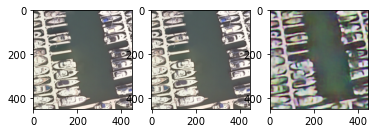

Orig  0.0609243701079066 0.9803921580314636
Gen  0.0 1.0


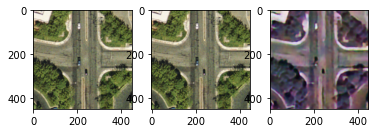

Orig  0.10602241210943722 0.9822529022182742
Gen  0.0 1.0


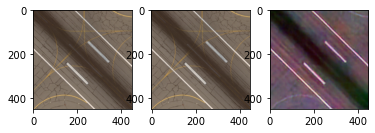

Orig  0.0 1.0
Gen  0.0 1.0


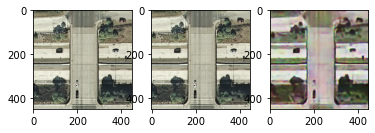

Orig  0.09523809701204342 0.87881153183324
Gen  0.0 1.0


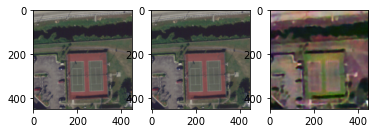

Orig  0.001980792398431263 1.0
Gen  0.0 1.0


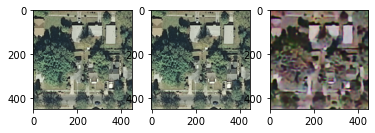

Orig  0.2884754027639112 0.8151460694415229
Gen  0.0 1.0


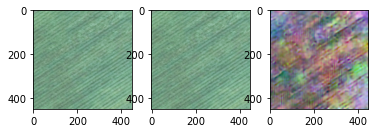

Orig  0.027130853085381705 0.9489595868757794
Gen  0.0 1.0


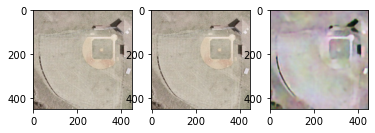

Orig  0.0 1.0
Gen  0.0 1.0


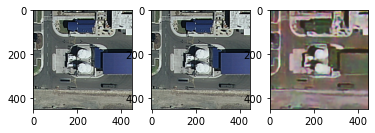

Orig  0.49467787161773574 0.9016806781291961
Gen  0.0 1.0


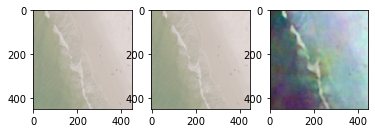

In [11]:
for i in range(10):
    index=np.random.randint(0,len(X_test_reshaped))

    X_test_im=np.expand_dims(X_test_reshaped[index],0)
    out_image=np.zeros_like(X_test_reshaped[index])
    
    out_image[:,:,0]=np.squeeze(model_1.predict(X_test_im[:,:,:,[1,2]]))
    out_image[:,:,1]=np.squeeze(model_2.predict(X_test_im[:,:,:,[0,2]]))
    out_image[:,:,2]=np.squeeze(model_3.predict(X_test_im[:,:,:,[0,1]]))
    
    im_min=out_image.min(axis=(0, 1), keepdims=True)
    im_max=out_image.max(axis=(0, 1), keepdims=True)
    out_image=(out_image-im_min)/(im_max-im_min)
    
    
    print("Orig ",np.min(X_test_im),np.max(X_test_im))
    print("Gen ",np.min(out_image),np.max(out_image))
    fig=plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_reshaped[index])
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(X_test_im))
    plt.subplot(1,3,3)
    plt.imshow(out_image)
    plt.show()

## Evaluate with MSE loss

Orig  0.0 0.476470589637756
Gen  0.0 1.0


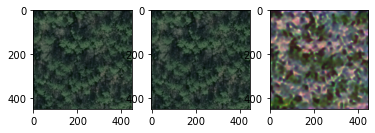

Orig  0.13181273213454633 0.9682072848081589
Gen  0.0 1.0


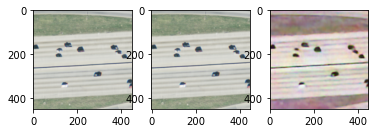

Orig  0.24109644442796618 0.7837735222918645
Gen  0.0 1.0


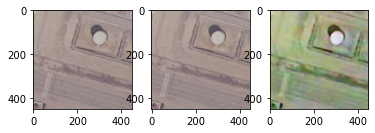

Orig  0.11404561893824405 0.9411764740943909
Gen  0.0 1.0


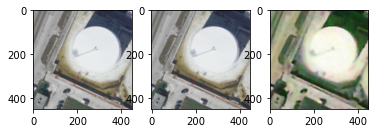

Orig  0.04551820854219224 1.0
Gen  0.0 1.0


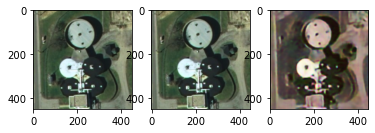

Orig  0.2647859283855984 0.9071428626775748
Gen  0.0 1.0


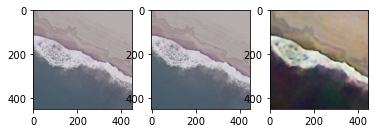

Orig  0.043957584138427645 0.9803921580314636
Gen  0.0 1.0


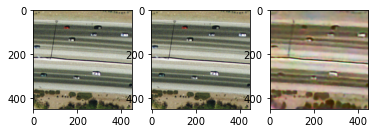

Orig  0.09429772091763361 0.9960784316062927
Gen  0.0 1.0


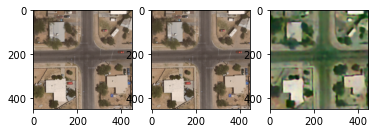

Orig  0.0 0.9137254953384399
Gen  0.0 1.0


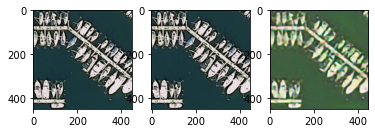

Orig  0.0 0.5578831796135223
Gen  0.0 1.0


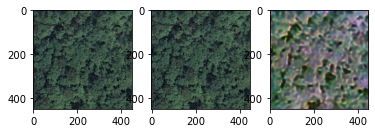

In [5]:
model_1=load_model('../ssd/proxy_models/splitbrain_m1_epoch50_mseloss_ucmerced')
model_2=load_model('../ssd/proxy_models/splitbrain_m2_epoch50_mseloss_ucmerced')
model_3=load_model('../ssd/proxy_models/splitbrain_m3_epoch50_mseloss_ucmerced')



for i in range(10):
    index=np.random.randint(0,len(X_test_reshaped))

    X_test_im=np.expand_dims(X_test_reshaped[index],0)
    out_image=np.zeros_like(X_test_reshaped[index])
    
    out_image[:,:,0]=np.squeeze(model_1.predict(X_test_im[:,:,:,[1,2]]))
    out_image[:,:,1]=np.squeeze(model_2.predict(X_test_im[:,:,:,[0,2]]))
    out_image[:,:,2]=np.squeeze(model_3.predict(X_test_im[:,:,:,[0,1]]))
    
    im_min=out_image.min(axis=(0, 1), keepdims=True)
    im_max=out_image.max(axis=(0, 1), keepdims=True)
    out_image=(out_image-im_min)/(im_max-im_min)
    
    
    print("Orig ",np.min(X_test_im),np.max(X_test_im))
    print("Gen ",np.min(out_image),np.max(out_image))
    fig=plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(X_test_reshaped[index])
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(X_test_im))
    plt.subplot(1,3,3)
    plt.imshow(out_image)
    plt.show()